In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

In [1]:
pip install tensorflow==2.7.0

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow==2.7.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0)
ERROR: No matching distribution found for tensorflow==2.7.0

[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", shuffle = True, image_size = (IMAGE_SIZE,IMAGE_SIZE), batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[2 2 0 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 0 0]


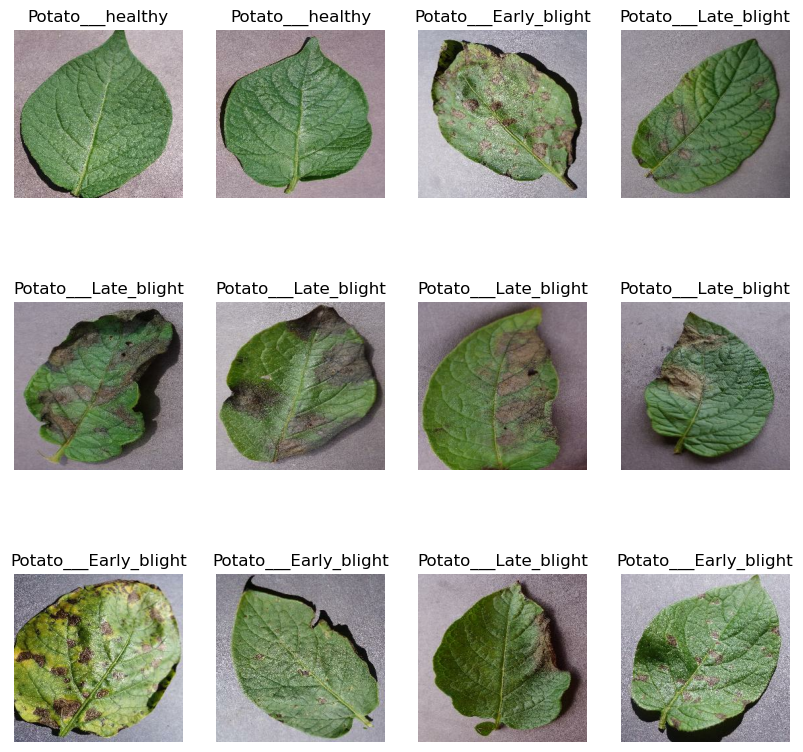

In [5]:
plt.figure(figsize = (10,10))
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [6]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    assert(train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
len(train_ds)

54

In [9]:
len(test_ds)

8

In [10]:
len(val_ds)

6

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale, data_augmentation, layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'), 
        layers.MaxPooling2D((2,2)), 
        layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation = 'relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation = 'relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation = 'relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation = 'relu'),
        layers.Dense(n_classes, activation = 'softmax')
    ])
model.build(input_shape= input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [16]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [17]:
history = model.fit(
    train_ds, batch_size = BATCH_SIZE,
    validation_data = val_ds, verbose = 1,
    epochs = EPOCHS
)

Epoch 1/50
46/54 [========================>.....] - ETA: 9s - loss: 0.9433 - accuracy: 0.4966 

KeyboardInterrupt: 

In [ ]:
score = model.evaluate(test_ds)